#  AGN fraction vs Ne Spectral Lines Ratios

Import of the libraries

In [1]:
from astropy.table import Table, Column, table, vstack, join
from pathlib import Path

import numpy as np
import astropy.units as u

from matplotlib import pyplot as plt

Reading the different paths where the results has been saved

In [2]:
path_raw = '../Datos/Raw/'
path_phot_ned = '../Datos/Work/Phot_Tables_NED/' #In this path wi will save the photometry tables for each object
path_phot_cds = '../Datos/Work/Phot_Tables_CDS/'
path_SED = '../Datos/Work/SEDs/'
path_CIGALE_phot = '../Datos/Work/CIGALE_InputPhot/'
path_CIGALE_out = '../Datos/Work/CIGALE_Output/'
path_graphs = '../Datos/Final/Graphics/'
path_FINAL = '../Datos/Final/'

In [3]:
date_sample = 'Sep_02_2022'
Ne_Sy = Table.read(path_raw+'Obj_Sy_Ne-IR_'+date_sample+'.vot',format='votable')

We remove the galaxies without energy balance that was removed in the CIGALE's phot files (Notebook 04).

In [4]:
CIG_BadGalaxies = Table.read('../Datos/Complementary/CIGPhot_BadEnergyBalance.tbl', format='ascii')
for id in CIG_BadGalaxies['id']:
    Ne_Sy.remove_rows(np.where(Ne_Sy['Main_Id'] == id)[0])

Now we classify the tables according to their Ne line information

In [5]:
NeV_NeII_Sy = vstack([Ne_Sy[Ne_Sy['NED_Ne_IR_info']=='NeII|NeIII|NeV'],\
                    Ne_Sy[Ne_Sy['NED_Ne_IR_info']=='NeII|NeV']])

NeV_NeIII_Sy = vstack([Ne_Sy[Ne_Sy['NED_Ne_IR_info']=='NeII|NeIII|NeV'],\
                    Ne_Sy[Ne_Sy['NED_Ne_IR_info']=='NeIII|NeV']])

NeIII_NeII_Sy = vstack([Ne_Sy[Ne_Sy['NED_Ne_IR_info']=='NeII|NeIII|NeV'],\
                    Ne_Sy[Ne_Sy['NED_Ne_IR_info']=='NeII|NeIII']])

print('Total objects with [NeV] and [NeII] info:',len(NeV_NeII_Sy))
print('Total objects with [NeV] and [NeIII] info:',len(NeV_NeIII_Sy))
print('Total objects with [NeIII] and [NeII] info:',len(NeIII_NeII_Sy))

Total objects with [NeV] and [NeII] info: 180
Total objects with [NeV] and [NeIII] info: 178
Total objects with [NeIII] and [NeII] info: 221


## Extracting the Neon lines flux values from NED phot tables

In [6]:
def Neon_info(NED_table, Freq):
    
    '''
    This function create a new table from the Phot NED table
    but with the flux of [NeII] and [NeV]
    '''
    
    NED_table.remove_rows(np.where(NED_table['Flux_Density'].mask)[0])
    NED_table.remove_rows(np.where(NED_table['NED_Units'] == 'Jy')[0])
    NED_table.remove_rows(np.where(NED_table['Observed_Passband'] == '[Cl II] line (IRS)')[0])
    NED_table.remove_rows(np.where(NED_table['Observed_Passband'] == '[Cl II] 14.4 (IRS)')[0])
    NED_table.remove_rows(np.where(NED_table['Observed_Passband'] == '[Cl II] (IRS)')[0])
    NED_table.remove_rows(np.where(NED_table['Observed_Passband'] == '[Cl II] 14.37 (IRS)')[0])
    
    Ne_idx = [np.where(NED_table['Frequency'] == freq)[0] for freq in Freq]
    #print(Ne_idx)
    #print(len(Ne_idx))
    i = []
    Ne_table = Table()
    for idx in range(len(Freq)):
        Ne_table = vstack([Ne_table,NED_table[Ne_idx[idx]]])
    
    for ind in range(len(Ne_table)):
        i.append(ind)
    
    Ne_table['idx'] = i
    Ne_inf = Ne_table['idx','Observed_Passband','Flux_Density','NED_Uncertainty','NED_Units','Refcode']
    obs_passb = np.unique(Ne_inf['Observed_Passband'])
    #print(obs_passb)
    return Ne_inf

## Calculating the ratios: [NeV]/[NeII], [NeV]/[NeIII] and [NeIII]/[NeII]

In [7]:
def Ne_ratios(Ne_info,Nel1,Nel2,Nel1a,Nel2a,not_same_bib):
    
    '''
    This function is for compute the ratio between two Neon
    emission lines (line1/line2) that have the same bibcode
    '''
    #Extract the number value of the NED_Uncertainty
    for u in range(len(Ne_info)):
        #print(u,Ne_info['NED_Uncertainty'][u])
        if Ne_info['NED_Uncertainty'][u] != '':
            Ne_info['NED_Uncertainty'][u] = float(Ne_info['NED_Uncertainty'][u].split('+/-')[-1])
    
    bibcod, count = np.unique(Ne_info['Refcode'], return_counts=True)
    print('No. of [Ne] data',len(Ne_info))
    flag = 0 #Flag to detect when there is not info of the two Ne lines for the same bibcode
    
    #Print the lines passband names
    #print('Neon line 1:',Nel1,'& Neon line 2:',Nel2)
    #print('Others filter names for Neon line1:',Nel1a,'& Neon line 2:',Nel2a)
    
    Ne_ratio = []
    Ne_ratio_err = []
    Ne_filter = []
    refcode = []
    #print(Ne_info) #Print the Ne Info of each galaxy
    
    for idx,bib in enumerate(bibcod):
        i = np.where(Ne_info['Refcode'] == bib)[0]
        #The ratio [Ne]line1/[Ne]line2 is calculated for only the bibcodes that have both flux data
        if len(i)>=2:
            flag += 1
            #print(len(i))
            Neline1_i = 'nan'
            Neline2_i = 'nan'
            for j,ind in enumerate(i):
                if Nel1 in Ne_info['Observed_Passband'][ind] or Nel1a in Ne_info['Observed_Passband'][ind]:
                    #print('yes:',Nel1)
                    Neline1_i = ind
                elif Nel2 in Ne_info['Observed_Passband'][ind] or Nel2a in Ne_info['Observed_Passband'][ind]:
                    #print('yes:',Nel2)
                    Neline2_i = ind
            if Neline1_i != 'nan' and Neline2_i != 'nan':
                Neline1 = Ne_info['Flux_Density'][Neline1_i]
                Neline1_err = Ne_info['NED_Uncertainty'][Neline1_i]
                Neline2 = Ne_info['Flux_Density'][Neline2_i]
                Neline2_err = Ne_info['NED_Uncertainty'][Neline2_i]
                Neline1_Neline2 = Neline1/Neline2
                Ne_ratio.append(Neline1_Neline2)
                Ne_filter.append(Ne_info['Observed_Passband'][Neline1_i])
                Ne_filter.append(Ne_info['Observed_Passband'][Neline2_i])
                refcode.append(bib)
                #print('For bibcode',',',bib,Nel1,'index is:',Neline1_i,'and',Nel2,'index is:',Neline2_i)
                #print('For bibcode', bib,Nel1,'/',Nel2,'ratio is:',Neline1_Neline2)
                if Neline1_err != '' or Neline2_err != '':
                    Neline1_Neline2_err = np.absolute(Neline1_Neline2)*\
                    np.sqrt((Neline1_err/Neline1)**2+(Neline2_err/Neline2)**2)
                    #Neline1_Neline2_err = Neline1_err/Neline2_err
                else:
                    Neline1_Neline2_err = np.nan #Se usa np.nan para poder hacer operaciones mat con este
                Ne_ratio_err.append(Neline1_Neline2_err)
            #In some cases there is two data for one bibcode but for the same spectral line
            elif (Neline1_i == 'nan' and Neline2_i != 'nan') and len(Ne_info)==2:
                flag = 0
    if flag<1:
        not_same_bib += 1
        #for r in range(len(NeV_NeII_inf)): refcode.append(NeV_NeII_inf['Refcode'][r])
         
    return Ne_ratio, Ne_ratio_err, Ne_filter, refcode, not_same_bib

In the galaxies where there are more than one data of [NeII] or [NeV], we remove the rows if per bibcode there is data for only one the them. The idea is to have both [NeII] and [NeV] data per bibcode:

## [NeV]/[NeII]

In [8]:
Nefilter = []
Refcode = []
NeV_NeII = Table(names=('Main_id','RA','DEC','otype','redshift','[NeV]/[NeII]','[NeV]/[NeII]_err'),
                dtype=('O','f8','f8','O','f8','f8','f8'))
NeV_NeII_bib = Table(names=('Main_id','RA','DEC','otype','redshift','[NeV]/[NeII]','[NeV]/[NeII]_err','Bibcode'),
                dtype=('O','f8','f8','O','f8','f8','f8','O'))

not_same_bib = 0

for id in range(len(NeV_NeII_Sy)):
    NED_phot = Table()
    obj = NeV_NeII_Sy['Main_Id'][id]
    ra = NeV_NeII_Sy['RA'][id]
    dec = NeV_NeII_Sy['DEC'][id]
    otype = NeV_NeII_Sy['otype_txt'][id]
    z = NeV_NeII_Sy['redshift'][id]
    print(id)
    print('Galaxy: ',obj)

    NED_phot = Table.read(path_phot_ned+obj+'_NED_phot_tables'+'.vot', format='votable')
    print('Phot table lenght:',len(NED_phot))
    
    NeV_NeII_Freq = [20900000000000.0,21000000000000.0,23400000000000.0]
    NeV_NeII_inf = Neon_info(NED_phot, NeV_NeII_Freq)
    
    NeV_NeII_ratios,NeV_NeII_ratios_err,Ne_filter,refcode,not_same_bib = \
    Ne_ratios(NeV_NeII_inf,'[Ne V]','[Ne II]','nan','nan',not_same_bib)
    
    for r in range(len(refcode)): Refcode.append(refcode[r])
    for f in range(len(Ne_filter)): Nefilter.append(Ne_filter[f])
        
    avg_Ne_ratios = np.average(NeV_NeII_ratios)
    std_Ne_ratios = np.std(NeV_NeII_ratios)
    err = np.sqrt(np.sum(np.array(NeV_NeII_ratios_err)**2))/len(NeV_NeII_ratios_err)
    NeV_NeII_row = [obj,ra,dec,otype,z,avg_Ne_ratios,err]
    NeV_NeII.add_row(vals=NeV_NeII_row)
    
    for b,ratio in enumerate(NeV_NeII_ratios):
        NeV_NeII_bib_row = [obj,ra,dec,otype,z,ratio,NeV_NeII_ratios_err[b],refcode[b]]
        NeV_NeII_bib.add_row(vals=NeV_NeII_bib_row)

    print(NeV_NeII_ratios)
    print(NeV_NeII_ratios_err)
    print(refcode)
    print('\n')
    
print('Number of galaxies with diferent bibcode for [NeV] and [NeII] fluxes:',not_same_bib)
print('Galaxies idx with diferent bibcode for [NeV] and [NeII] fluxes:',\
      np.where(np.isnan(NeV_NeII['[NeV]/[NeII]']))[0])

#Uncomment the 'for' lines for print the 'Observed_passband'and the Ŕefcodes' with [NeV] and [NeII] information
Ne_filters1, countspb1 = np.unique(Nefilter, return_counts=True)
#for pb in range(len(Ne_filters1)): print(Ne_filters1[pb])
    
refcodes1, countsrc1 = np.unique(Refcode, return_counts=True)
#for rc in range(len(refcodes1)): print(refcodes1[rc])

0
Galaxy:  3C 234.0
Phot table lenght: 253
No. of [Ne] data 4
[4.125]
[1.3524428130239001]
['2006ApJ...647..161O']


1
Galaxy:  NGC   262
Phot table lenght: 334
No. of [Ne] data 7
[0.3548780487804878, 0.45098039215686275, 0.3548780487804878]
[0.022645479318087677, 0.03208429446652159, nan]
['2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJS..195...17W']


2
Galaxy:  IRAS 04385-0828
Phot table lenght: 97
No. of [Ne] data 5
[0.16402877697841728, 0.16402877697841728]
[0.0343865128420725, nan]
['2010ApJ...709.1257T', '2011ApJS..195...17W']


3
Galaxy:  Mrk  279
Phot table lenght: 188
No. of [Ne] data 5
[0.4275184275184275]
[0.030864694616613318]
['2011ApJ...740...94D']


4
Galaxy:  Mrk 1239
Phot table lenght: 145
No. of [Ne] data 5
[0.3617021276595745, 0.3617021276595745]
[0.03194737630815746, nan]
['2010ApJ...709.1257T', '2011ApJS..195...17W']


5
Galaxy:  NGC  3735
Phot table lenght: 93
No. of [Ne] data 2
[0.7553191489361702]
[nan]
['2010ApJ...725.2270P']


6
Galaxy:  LEDA   89511
P

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_342880/933150259.py:34: RuntimeWarning: invalid value encountered in double_scalars
 

[]
[]
[]


13
Galaxy:  [VV2000] J235225.0+244009
Phot table lenght: 56
No. of [Ne] data 2
[0.2967741935483871]
[nan]
['2011ApJS..193...18W']


14
Galaxy:  NGC  2622
Phot table lenght: 142
No. of [Ne] data 4
[0.39838709677419354]
[0.0375643636396252]
['2011ApJ...740...94D']


15
Galaxy:  NGC   863
Phot table lenght: 198
No. of [Ne] data 4
[0.2917682926829268]
[0.05343810906853561]
['2011ApJ...740...94D']


16
Galaxy:  IRAS 11215-2806
Phot table lenght: 19
No. of [Ne] data 2
[1.7333333333333334]
[nan]
['2010ApJ...725.2270P']


17
Galaxy:  NGC  3281
Phot table lenght: 150
No. of [Ne] data 4
[2.386934673366834, 2.764705882352941]
[0.2936348905958634, nan]
['2010ApJ...716.1151W', '2010ApJ...725.2270P']


18
Galaxy:  LEDA  101275
Phot table lenght: 116
No. of [Ne] data 3
[0.5664335664335665]
[nan]
['2011ApJS..193...18W']


19
Galaxy:  NAME Circinus Galaxy
Phot table lenght: 258
No. of [Ne] data 9
[0.5128805620608899, 0.4801762114537445, 0.3522222222222222]
[nan, 0.027020531602903866, nan]
['

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_342880/933150259.py:34: RuntimeWarning: invalid value encountered in double_scalars
 

Phot table lenght: 124
No. of [Ne] data 5
[0.14615384615384616, 0.14921875]
[0.033389071572696924, nan]
['2010ApJ...716.1151W', '2011ApJS..195...17W']


42
Galaxy:  ESO 383-35
Phot table lenght: 271
No. of [Ne] data 11
[1.3841961852861036, 1.0060240963855422, 1.4404761904761905, 1.0060240963855422]
[nan, 0.1524210995249283, 0.1855737551079056, nan]
['2009ApJ...690.1105K', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJS..195...17W']


43
Galaxy:  NGC   973
Phot table lenght: 105
No. of [Ne] data 2
[0.2577833125778331]
[0.022601371918987024]
['2010ApJ...716.1151W']


44
Galaxy:  2E  3648
Phot table lenght: 181
No. of [Ne] data 3
[1.7878787878787878]
[0.279439361062646]
['2007ApJ...660..117C']


45
Galaxy:  2MASX J22041914+0333511
Phot table lenght: 67
No. of [Ne] data 2
[1.4]
[nan]
['2011ApJS..195...17W']


46
Galaxy:  NGC  7469
Phot table lenght: 575
No. of [Ne] data 14
[0.07246376811594203, 0.06, 0.08020833333333334, 0.04670391061452514]
[nan, nan, 0.005329067600533414, nan]
['

Phot table lenght: 85
No. of [Ne] data 2
[0.24021739130434783]
[0.0336275842556265]
['2011ApJ...740...94D']


87
Galaxy:  ESO 428-14
Phot table lenght: 124
No. of [Ne] data 4
[1.234251968503937]
[nan]
['2009ApJ...690.1105K']


88
Galaxy:  NGC  5347
Phot table lenght: 154
No. of [Ne] data 7
[0.3872832369942196, 0.4988009592326139, 0.4988009592326139]
[nan, 0.19235465257108375, nan]
['2009ApJ...690.1105K', '2010ApJ...709.1257T', '2011ApJS..195...17W']


89
Galaxy:  NGC  4748
Phot table lenght: 158
No. of [Ne] data 6
[1.0714285714285714, 0.9158751696065129]
[0.10468512514634282, nan]
['2007ApJ...671..124D', '2011ApJS..195...17W']


90
Galaxy:  NGC  1667
Phot table lenght: 169
No. of [Ne] data 6
[0.1306930693069307, 0.1306930693069307]
[0.02603362899730117, nan]
['2010ApJ...709.1257T', '2011ApJS..195...17W']


91
Galaxy:  NGC  1320
Phot table lenght: 128
No. of [Ne] data 6
[0.8888888888888888, 1.116910229645094, 0.8888888888888888]
[0.14866166146657153, 0.0556451153047063, nan]
['2007ApJ..

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_342880/933150259.py:34: RuntimeWarning: invalid value encountered in double_scalars
 

Phot table lenght: 187
No. of [Ne] data 5
[0.05042918454935622]
[0.00404087056194164]
['2010ApJ...716.1151W']


127
Galaxy:  UGC 12138
Phot table lenght: 120
No. of [Ne] data 2
[2.0]
[0.7453559924999299]
['2007ApJ...671..124D']


128
Galaxy:  IC 2560
Phot table lenght: 122
No. of [Ne] data 2
[1.1875]
[nan]
['2010ApJ...725.2270P']


129
Galaxy:  NGC  5995
Phot table lenght: 153
No. of [Ne] data 8
[0.8571428571428571, 0.3715151515151515, 0.5714285714285714, 0.3715151515151515]
[0.09407698425809068, 0.025313014737480592, 0.13466029660005585, nan]
['2007ApJ...671..124D', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJS..195...17W']


130
Galaxy:  2MASSI J0918486+211717
Phot table lenght: 73
No. of [Ne] data 2
[4.562118126272912]
[nan]
['2009ApJ...690.1105K']


131
Galaxy:  LEDA   17155
Phot table lenght: 266
No. of [Ne] data 7
[0.8518518518518519, 0.796875, 1.1875]
[0.18714943898875788, 0.07259959401235218, nan]
['2007ApJ...656..148A', '2011ApJ...740...94D', '2011ApJS..195...17W']



/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_342880/933150259.py:34: RuntimeWarning: invalid value encountered in double_scalars
 

Phot table lenght: 425
No. of [Ne] data 16
[1.0588235294117647, 0.6726190476190477, 0.5047169811320755, 0.5177664974619289, 0.6470588235294118, 0.6242774566473989, 0.5047169811320755]
[0.171341431185328, 0.03200680723936727, 0.018083975533853824, 0.04090642225496949, nan, 0.028650487974464286, nan]
['2007ApJ...671..124D', '2009MNRAS.398.1165G', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2010ApJ...725.2270P', '2011ApJ...740...94D', '2011ApJS..195...17W']


137
Galaxy:  LEDA   70560
Phot table lenght: 78
No. of [Ne] data 2
[0.6222910216718266]
[0.09525666098581355]
['2011ApJ...740...94D']


138
Galaxy:  Mrk  705
Phot table lenght: 181
No. of [Ne] data 2
[0.5774378585086042]
[0.03804586236067253]
['2011ApJ...740...94D']


139
Galaxy:  UGC  3601
Phot table lenght: 69
No. of [Ne] data 2
[0.3821292775665399]
[0.044754725451438174]
['2010ApJ...716.1151W']


140
Galaxy:  ESO  33-2
Phot table lenght: 126
No. of [Ne] data 3
[2.0861423220973783]
[0.252525703158059]
['2010ApJ...716.1151W']


1

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_342880/933150259.py:34: RuntimeWarning: invalid value encountered in double_scalars
 

[]
[]
[]


170
Galaxy:  NGC  4602
Phot table lenght: 83
No. of [Ne] data 2
[0.25]
[0.06987712429686843]
['2007ApJ...671..124D']


171
Galaxy:  IRAS 13342+3932
Phot table lenght: 97
No. of [Ne] data 2
[0.633147113594041]
[0.022457192734740374]
['2011ApJ...740...94D']


172
Galaxy:  Mrk 1298
Phot table lenght: 81
No. of [Ne] data 2
[3.1223021582733814]
[nan]
['2006ApJ...649...79S']


173
Galaxy:  2MASX J14510879+2709272
Phot table lenght: 99
No. of [Ne] data 2
[5.266272189349112]
[nan]
['2006ApJ...649...79S']


174
Galaxy:  MCG+13-07-002
Phot table lenght: 100
No. of [Ne] data 2
[0.7883211678832117]
[nan]
['2006ApJ...649...79S']


175
Galaxy:  LEDA    1790
Phot table lenght: 161
No. of [Ne] data 4
[2.0655021834061134]
[nan]
['2006ApJ...649...79S']


176
Galaxy:  Ton  1565
Phot table lenght: 120
No. of [Ne] data 3
[0.5305719921104537]
[nan]
['2006ApJ...649...79S']


177
Galaxy:  2E  2389
Phot table lenght: 180
No. of [Ne] data 2
[1.1556064073226544]
[0.17151303566833198]
['2011ApJ...740..

In [9]:
#Remove the galaxies where there was not info with same bibcode
NeV_NeII.remove_rows(np.where(np.isnan(NeV_NeII['[NeV]/[NeII]']))[0])
NeV_NeII_bib.remove_rows(np.where(np.isnan(NeV_NeII['[NeV]/[NeII]']))[0])

In [10]:
print('Final number of galaxies with [Ne V] and [Ne II] info: ', len(NeV_NeII))

Final number of galaxies with [Ne V] and [Ne II] info:  175


## [NeV]/[NeIII]

In [11]:
Nefilter = []
Refcode = []
NeV_NeIII = Table(names=('Main_id','RA','DEC','otype','redshift','[NeV]/[NeIII]','[NeV]/[NeIII]_err'),
                 dtype=('O','f8','f8','O','f8','f8','f8'))
NeV_NeIII_bib = Table(names=('Main_id','RA','DEC','otype','redshift','[NeV]/[NeIII]',\
                             '[NeV]/[NeIII]_err','Bibcode'),
                dtype=('O','f8','f8','O','f8','f8','f8','O'))

not_same_bib = 0

for id in range(len(NeV_NeIII_Sy)):
    NED_phot = Table()
    obj = NeV_NeIII_Sy['Main_Id'][id]
    ra = NeV_NeIII_Sy['RA'][id]
    dec = NeV_NeIII_Sy['DEC'][id]
    otype = NeV_NeIII_Sy['otype_txt'][id]
    z = NeV_NeIII_Sy['redshift'][id]
    print(id)
    print('Galaxy: ',obj)

    NED_phot = Table.read(path_phot_ned+obj+'_NED_phot_tables'+'.vot', format='votable')
    print('Phot table lenght:',len(NED_phot))
    
    #Put first the frequencies of the Ne line 1 and then the Ne line 2
    NeV_NeIII_Freq = [20900000000000.0,21000000000000.0,19200000000000.0,19300000000000.0]
    NeV_NeIII_inf = Neon_info(NED_phot, NeV_NeIII_Freq)
    
    NeV_NeIII_ratios,NeV_NeIII_ratios_err,Ne_filter,refcode,not_same_bib = \
    Ne_ratios(NeV_NeIII_inf,'[Ne V]','[Ne III]','nan','[NeIII]',not_same_bib)
    
    for r in range(len(refcode)): Refcode.append(refcode[r])
    for f in range(len(Ne_filter)): Nefilter.append(Ne_filter[f])
        
    avg_Ne_ratios = np.average(NeV_NeIII_ratios)
    std_Ne_ratios = np.std(NeV_NeIII_ratios)
    err = np.sqrt(np.sum(np.array(NeV_NeIII_ratios_err)**2))/len(NeV_NeIII_ratios_err)
    NeV_NeIII_row = [obj,ra,dec,otype,z,avg_Ne_ratios,err]
    NeV_NeIII.add_row(vals=NeV_NeIII_row)
    
    for b,ratio in enumerate(NeV_NeIII_ratios):
        NeV_NeIII_bib_row = [obj,ra,dec,otype,z,ratio,NeV_NeIII_ratios_err[b],refcode[b]]
        NeV_NeIII_bib.add_row(vals=NeV_NeIII_bib_row)
    
    print(NeV_NeIII_ratios)
    print(NeV_NeIII_ratios_err)
    print(refcode)
    print('\n')

print('Number of galaxies with diferent bibcode for [NeV] and [NeIII] fluxes:',not_same_bib)
print('Galaxies idx with diferent bibcode for [NeV] and [NeIII] fluxes:',\
      np.where(np.isnan(NeV_NeIII['[NeV]/[NeIII]']))[0])

#Uncomment the 'for' lines for print the 'Observed_passband'and the Ŕefcodes' with [NeV] and [NeIII] information
Ne_filters2, countspb2 = np.unique(Nefilter, return_counts=True)
#for pb in range(len(Ne_filters2)): print(Ne_filters2[pb])
    
refcodes2, countsrc2 = np.unique(Refcode, return_counts=True)
#for rc in range(len(refcodes2)): print(refcodes2[rc])

0
Galaxy:  3C 234.0
Phot table lenght: 253
No. of [Ne] data 4
[0.4024390243902439, 0.6911764705882353]
[0.09201936826462354, 0.100914932142928]
['2006ApJ...647..161O', '2010ApJ...709.1257T']


1
Galaxy:  NGC   262
Phot table lenght: 334
No. of [Ne] data 7
[0.2852941176470588, 0.33495145631067963, 0.2852941176470588]
[0.017961061968501214, 0.021688727467788264, nan]
['2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJS..195...17W']


2
Galaxy:  IRAS 04385-0828
Phot table lenght: 97
No. of [Ne] data 5
[0.32294617563739375, 0.32294617563739375]
[0.06916357647608341, nan]
['2010ApJ...709.1257T', '2011ApJS..195...17W']


3
Galaxy:  Mrk  279
Phot table lenght: 188
No. of [Ne] data 5
[0.43283582089552236]
[0.03462284221323469]
['2011ApJ...740...94D']


4
Galaxy:  Mrk 1239
Phot table lenght: 145
No. of [Ne] data 4
[0.3624733475479744, 0.3624733475479744]
[0.029546122420736395, nan]
['2010ApJ...709.1257T', '2011ApJS..195...17W']


5
Galaxy:  NGC  3735
Phot table lenght: 93
No. of [Ne] data 2

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_342880/3320866453.py:36: RuntimeWarning: invalid value encountered in double_scalars


Phot table lenght: 142
No. of [Ne] data 3
[0.3072139303482587]
[0.028189266908607683]
['2011ApJ...740...94D']


15
Galaxy:  NGC   863
Phot table lenght: 198
No. of [Ne] data 4
[0.45355450236966827]
[0.09498521301064156]
['2011ApJ...740...94D']


16
Galaxy:  IRAS 11215-2806
Phot table lenght: 19
No. of [Ne] data 2
[0.5]
[nan]
['2010ApJ...725.2270P']


17
Galaxy:  NGC  3281
Phot table lenght: 150
No. of [Ne] data 4
[0.8133561643835616, 0.8103448275862069]
[0.05839841054566623, nan]
['2010ApJ...716.1151W', '2010ApJ...725.2270P']


18
Galaxy:  LEDA  101275
Phot table lenght: 116
No. of [Ne] data 2
[0.23142857142857143]
[nan]
['2011ApJS..193...18W']


19
Galaxy:  NAME Circinus Galaxy
Phot table lenght: 258
No. of [Ne] data 7
[0.5778364116094987, 0.545, 0.9462686567164179]
[nan, 0.028070115893063213, nan]
['2010ApJ...725.2270P', '2011ApJ...740...94D', '2011ApJS..195...17W']


20
Galaxy:  IC 3639
Phot table lenght: 188
No. of [Ne] data 6
[0.2647058823529412, 0.3333333333333333, 0.414814814814

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_342880/3320866453.py:36: RuntimeWarning: invalid value encountered in double_scalars


Phot table lenght: 271
No. of [Ne] data 11
[0.8488372093023255, 0.7514792899408284, 0.8520408163265306, 0.9138972809667674, 0.8520408163265306]
[nan, nan, 0.11920855509748761, 0.1235123298283933, nan]
['2007ApJ...655L..73G', '2009ApJ...690.1105K', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJS..195...17W']


43
Galaxy:  NGC   973
Phot table lenght: 105
No. of [Ne] data 2
[0.2320627802690583]
[0.02247090765432689]
['2010ApJ...716.1151W']


44
Galaxy:  2E  3648
Phot table lenght: 181
No. of [Ne] data 4
[0.75, 0.7283950617283951]
[nan, 0.12011916377404842]
['2007ApJ...655L..73G', '2007ApJ...660..117C']


45
Galaxy:  2MASX J22041914+0333511
Phot table lenght: 67
No. of [Ne] data 2
[0.5907801418439717]
[nan]
['2011ApJS..195...17W']


46
Galaxy:  NGC  7469
Phot table lenght: 575
No. of [Ne] data 13
[0.43103448275862066, 0.3333333333333333, 0.4301675977653631, 0.24807121661721068]
[nan, nan, 0.029350715220541432, nan]
['2009ApJ...690.1105K', '2010ApJ...725.2270P', '2011ApJ...740...94

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_342880/3320866453.py:36: RuntimeWarning: invalid value encountered in double_scalars


Phot table lenght: 130
No. of [Ne] data 2
[0.48600883652430044]
[0.033068698253822096]
['2010ApJ...716.1151W']


67
Galaxy:  Mrk  618
Phot table lenght: 127
No. of [Ne] data 4
[0.7230483271375465, 0.7230483271375465]
[0.10616729760599929, nan]
['2010ApJ...709.1257T', '2011ApJS..195...17W']


68
Galaxy:  Mrk  609
Phot table lenght: 147
No. of [Ne] data 5
[1.0, 0.6825396825396826]
[0.24845199749997662, 0.08139731245843908]
['2007ApJ...671..124D', '2011ApJ...740...94D']


69
Galaxy:  NGC  3079
Phot table lenght: 331
No. of [Ne] data 9
[0.043859649122807015, 0.03791666666666667, 0.05646551724137931]
[nan, nan, nan]
['2007ApJ...655L..73G', '2010ApJ...725.2270P', '2011ApJS..195...17W']


70
Galaxy:  2C   94
Phot table lenght: 226
No. of [Ne] data 2
[0.37735849056603776]
[0.05836748377170459]
['2006ApJ...647..161O']


71
Galaxy:  NGC  5548
Phot table lenght: 420
No. of [Ne] data 15
[0.5697674418604651, 0.35714285714285715, 0.41759352881698686, 0.7427785419532325, 0.21690767519466073, 0.385085

Phot table lenght: 200
No. of [Ne] data 6
[2.0, 0.5226860254083484, 0.40611353711790393]
[0.5590169943749475, 0.11368474998569517, nan]
['2007ApJ...671..124D', '2010ApJ...716.1151W', '2011ApJS..195...17W']


106
Galaxy:  Mrk  273
Phot table lenght: 353
No. of [Ne] data 8
[0.30210772833723654, 0.33136094674556216, 0.36551724137931035]
[0.04093754294379856, 0.011217759251616787, nan]
['2007ApJ...656..148A', '2011ApJ...740...94D', '2011ApJS..193...18W']


107
Galaxy:  ICRF J134733.3+121724
Phot table lenght: 282
No. of [Ne] data 4
[0.15010570824524314, 0.5618729096989966]
[nan, 0.0834931740022381]
['2011ApJS..193...18W', '2012ApJ...747...95G']


108
Galaxy:  ESO 362-18
Phot table lenght: 190
No. of [Ne] data 6
[0.43658210947930576, 0.4399441340782123]
[0.02890784380195692, 0.05284629911000138]
['2010ApJ...709.1257T', '2010ApJ...716.1151W']


109
Galaxy:  IC  450
Phot table lenght: 233
No. of [Ne] data 4
[0.2553191489361702, 0.19046653144016226]
[0.02195913596312341, nan]
['2007ApJ...671..

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_342880/3320866453.py:36: RuntimeWarning: invalid value encountered in double_scalars


Phot table lenght: 425
No. of [Ne] data 15
[0.782608695652174, 0.70625, 0.6257309941520468, 0.6219512195121951, 0.6875, 0.6666666666666666, 0.6257309941520468]
[0.11042027876378248, 0.033950935640771215, 0.024340660112324414, 0.04300354298684747, nan, 0.02686978100009198, nan]
['2007ApJ...671..124D', '2009MNRAS.398.1165G', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2010ApJ...725.2270P', '2011ApJ...740...94D', '2011ApJS..195...17W']


137
Galaxy:  LEDA   70560
Phot table lenght: 78
No. of [Ne] data 2
[0.78515625]
[0.12324657768645862]
['2011ApJ...740...94D']


138
Galaxy:  Mrk  705
Phot table lenght: 181
No. of [Ne] data 2
[0.6088709677419355]
[0.042319982784534686]
['2011ApJ...740...94D']


139
Galaxy:  UGC  3601
Phot table lenght: 69
No. of [Ne] data 2
[0.2644736842105263]
[0.016424770249573763]
['2010ApJ...716.1151W']


140
Galaxy:  ESO  33-2
Phot table lenght: 126
No. of [Ne] data 4
[0.6666666666666666, 0.6678657074340527]
[0.10015420209622192, 0.08074447606808172]
['2007ApJ...6

In [13]:
#Remove the galaxies where there was not info with same bibcode
NeV_NeIII.remove_rows(np.where(np.isnan(NeV_NeIII['[NeV]/[NeIII]']))[0])
NeV_NeIII_bib.remove_rows(np.where(np.isnan(NeV_NeIII['[NeV]/[NeIII]']))[0])

print('Final number of galaxies with [Ne V] and [Ne III] info: ', len(NeV_NeIII))

Final number of galaxies with [Ne V] and [Ne III] info:  174


## [NeIII]/[NeII]

In [14]:
Nefilter = []
Refcode = []
NeIII_NeII = Table(names=('Main_id','RA','DEC','otype','redshift','[NeIII]/[NeII]','[NeIII]/[NeII]_err'),
                   dtype=('O','f8','f8','O','f8','f8','f8'))
NeIII_NeII_bib = Table(names=('Main_id','RA','DEC','otype','redshift','[NeIII]/[NeII]','[NeIII]/[NeII]_err','Bibcode'),
                dtype=('O','f8','f8','O','f8','f8','f8','O'))

not_same_bib = 0

for id in range(len(NeIII_NeII_Sy)):
    NED_phot = Table()
    obj = NeIII_NeII_Sy['Main_Id'][id]
    ra = NeIII_NeII_Sy['RA'][id]
    dec = NeIII_NeII_Sy['DEC'][id]
    otype = NeIII_NeII_Sy['otype_txt'][id]
    z = NeIII_NeII_Sy['redshift'][id]
    print(id)
    print('Galaxy: ',obj)

    NED_phot = Table.read(path_phot_ned+obj+'_NED_phot_tables'+'.vot', format='votable')
    print('Phot table lenght:',len(NED_phot))
    
    #Put first the frequencies of the Ne line 1 and then the Ne line 2
    NeIII_NeII_Freq = [19200000000000.0,19300000000000.0,23400000000000.0]
    NeIII_NeII_inf = Neon_info(NED_phot, NeIII_NeII_Freq)
    
    NeIII_NeII_ratios,NeIII_NeII_ratios_err,Ne_filter,refcode,not_same_bib = \
    Ne_ratios(NeIII_NeII_inf,'[Ne III]','[Ne II]','[NeIII]','nan',not_same_bib)
    
    for r in range(len(refcode)): Refcode.append(refcode[r])
    for f in range(len(Ne_filter)): Nefilter.append(Ne_filter[f])
    
    avg_Ne_ratios = np.average(NeIII_NeII_ratios)
    std_Ne_ratios = np.std(NeIII_NeII_ratios)
    err = np.sqrt(np.sum(np.array(NeIII_NeII_ratios_err)**2))/len(NeIII_NeII_ratios_err)
    NeIII_NeII_row = [obj,ra,dec,otype,z,avg_Ne_ratios,err]
    NeIII_NeII.add_row(vals=NeIII_NeII_row)
    
    for b,ratio in enumerate(NeIII_NeII_ratios):
        NeIII_NeII_bib_row = [obj,ra,dec,otype,z,ratio,NeIII_NeII_ratios_err[b],refcode[b]]
        NeIII_NeII_bib.add_row(vals=NeIII_NeII_bib_row)

    print(NeIII_NeII_ratios)
    print(NeIII_NeII_ratios_err)
    print(refcode)
    print('\n')

print('Number of galaxies with diferent bibcode for [NeIII] and [NeII] fluxes:',not_same_bib)
print('Galaxies idx with diferent bibcode for [NeIII] and [NeII] fluxes:',\
      np.where(np.isnan(NeIII_NeII['[NeIII]/[NeII]']))[0])

#Uncomment the 'for' lines for print the 'Observed_passband'and the Ŕefcodes' with [NeIII] and [NeII] information
Ne_filters3, countspb3 = np.unique(Nefilter, return_counts=True)
#for pb in range(len(Ne_filters3)): print(Ne_filters3[pb])

refcodes3, countsrc3 = np.unique(Refcode, return_counts=True)
#for rc in range(len(refcodes3)): print(refcodes3[rc])

0
Galaxy:  3C 234.0
Phot table lenght: 253
No. of [Ne] data 4
[10.25]
[2.7077723778043086]
['2006ApJ...647..161O']


1
Galaxy:  NGC   262
Phot table lenght: 334
No. of [Ne] data 8
[1.9230769230769231, 1.2439024390243902, 1.34640522875817, 1.2439024390243902]
[0.16673376098941267, 0.03523648682068849, 0.08310665402417797, nan]
['2007ApJ...671..124D', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJS..195...17W']


2
Galaxy:  IRAS 04385-0828
Phot table lenght: 97
No. of [Ne] data 6
[0.75, 0.5079136690647482, 0.5079136690647482]
[0.10416666666666667, 0.03528595770676373, nan]
['2007ApJ...671..124D', '2010ApJ...709.1257T', '2011ApJS..195...17W']


3
Galaxy:  Mrk  279
Phot table lenght: 188
No. of [Ne] data 4
[1.5365853658536586, 0.9877149877149877]
[0.12675147981745505, 0.05999912237448755]
['2010ApJ...725..605S', '2011ApJ...740...94D']


4
Galaxy:  Mrk 1239
Phot table lenght: 145
No. of [Ne] data 5
[0.997872340425532, 0.997872340425532]
[0.0601417267924671, nan]
['2010ApJ...709.1257

Phot table lenght: 82
No. of [Ne] data 2
[1.4173913043478261]
[nan]
['2011ApJS..195...17W']


49
Galaxy:  UGC 12282
Phot table lenght: 52
No. of [Ne] data 2
[0.8461538461538461]
[0.11641422077045022]
['2010ApJ...716.1151W']


50
Galaxy:  MCG+10-17-021
Phot table lenght: 94
No. of [Ne] data 2
[0.9722222222222222]
[0.04381231303644306]
['2011ApJ...740...94D']


51
Galaxy:  ESO 113-45
Phot table lenght: 199
No. of [Ne] data 6
[1.383435582822086, 1.824742268041237, 2.083720930232558]
[nan, 0.44495362905464453, 0.2403068549506538]
['2009ApJ...690.1105K', '2010ApJ...716.1151W', '2011ApJ...740...94D']


52
Galaxy:  NGC  4388
Phot table lenght: 382
No. of [Ne] data 12
[1.206896551724138, 1.3838120104438643, 1.355081555834379, 1.4133333333333333, 1.3838120104438643]
[nan, 0.022738887435645852, 0.08326415425616346, nan, nan]
['2009ApJ...690.1105K', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2010ApJ...725.2270P', '2011ApJS..195...17W']


53
Galaxy:  NGC  5899
Phot table lenght: 114
No. of [Ne

Phot table lenght: 169
No. of [Ne] data 8
[0.7307692307692307, 0.7158415841584158, 0.69, 0.7158415841584158]
[0.04763681120741012, 0.03652896808709864, nan, nan]
['2007ApJ...671..124D', '2010ApJ...709.1257T', '2010ApJ...725.2270P', '2011ApJS..195...17W']


91
Galaxy:  NGC  1320
Phot table lenght: 128
No. of [Ne] data 6
[1.0, 1.4196242171189979, 1.0]
[0.15713484026367722, 0.06350186665000958, nan]
['2007ApJ...671..124D', '2010ApJ...709.1257T', '2011ApJS..195...17W']


92
Galaxy:  Mrk 1073
Phot table lenght: 133
No. of [Ne] data 2
[1.2451499118165785]
[0.02327796430576017]
['2011ApJ...740...94D']


93
Galaxy:  NGC  6300
Phot table lenght: 184
No. of [Ne] data 6
[1.3304347826086957, 1.3636363636363635, 1.3304347826086957]
[0.08814129868076209, nan, nan]
['2009MNRAS.398.1165G', '2010ApJ...725.2270P', '2011ApJS..195...17W']


94
Galaxy:  NGC  5643
Phot table lenght: 174
No. of [Ne] data 10
[1.3647642679900744, 1.2176724137931034, 1.4736842105263157, 1.2176724137931034]
[nan, 0.0967119725278

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_342880/3295515250.py:35: RuntimeWarning: invalid value encountered in double_scalars


No. of [Ne] data 7
[0.6363636363636364, 0.5439914163090128, 0.6363636363636364]
[0.10775541165624211, 0.06730713130748388, nan]
['2007ApJ...671..124D', '2010ApJ...716.1151W', '2011ApJS..195...17W']


127
Galaxy:  UGC 12138
Phot table lenght: 120
No. of [Ne] data 2
[2.6666666666666665]
[0.9493337494797256]
['2007ApJ...671..124D']


128
Galaxy:  IC 2560
Phot table lenght: 122
No. of [Ne] data 2
[2.25]
[nan]
['2010ApJ...725.2270P']


129
Galaxy:  NGC  5995
Phot table lenght: 153
No. of [Ne] data 8
[1.2857142857142858, 0.5133333333333333, 0.6909774436090226, 0.5133333333333333]
[0.16982976507237998, 0.029066578208979052, 0.10869498925705183, nan]
['2007ApJ...671..124D', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJS..195...17W']


130
Galaxy:  2MASSI J0918486+211717
Phot table lenght: 73
No. of [Ne] data 3
[2.6476578411405294]
[nan]
['2009ApJ...690.1105K']


131
Galaxy:  LEDA   17155
Phot table lenght: 266
No. of [Ne] data 6
[0.8611111111111112, 0.96875, 1.125]
[0.1237839197587688

Phot table lenght: 404
No. of [Ne] data 4
[0.12817109144542774, 0.1127659574468085]
[0.00887486743132394, nan]
['2007ApJ...656..148A', '2011ApJS..193...18W']


170
Galaxy:  LEDA   89032
Phot table lenght: 69
No. of [Ne] data 2
[1.1241379310344828]
[nan]
['2009ApJ...690.1105K']


171
Galaxy:  NGC  7479
Phot table lenght: 207
No. of [Ne] data 2
[0.6170212765957447]
[nan]
['2010ApJ...725.2270P']


172
Galaxy:  NGC  4477
Phot table lenght: 178
No. of [Ne] data 2
[0.875]
[nan]
['2010ApJ...725.2270P']


173
Galaxy:  Mrk  883
Phot table lenght: 124
No. of [Ne] data 4
[0.7272727272727273, 0.732824427480916]
[0.11240884717963176, 0.02548764148874196]
['2007ApJ...671..124D', '2010ApJ...725..605S']


174
Galaxy:  NGC  4235
Phot table lenght: 198
No. of [Ne] data 6
[1.002710027100271, 0.868421052631579, 0.9541547277936963]
[0.22937671231257023, nan, 0.06733331259959062]
['2010ApJ...716.1151W', '2010ApJ...725.2270P', '2011ApJ...740...94D']


175
Galaxy:  NGC  1056
Phot table lenght: 124
No. of [Ne]

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_342880/3295515250.py:35: RuntimeWarning: invalid value encountered in double_scalars


Phot table lenght: 189
No. of [Ne] data 2
[1.7]
[nan]
['2010ApJ...725.2270P']


192
Galaxy:  IRAS 03450+0055
Phot table lenght: 109
No. of [Ne] data 4
[1.6697247706422018, 1.6697247706422018]
[0.44639302066669045, nan]
['2010ApJ...709.1257T', '2011ApJS..195...17W']


193
Galaxy:  NGC  1204
Phot table lenght: 73
No. of [Ne] data 2
[0.09259259259259259]
[nan]
['2010ApJ...725.2270P']


194
Galaxy:  2C 1883
Phot table lenght: 196
No. of [Ne] data 2
[0.3215434083601286]
[0.03199976335108683]
['2012ApJ...747...95G']


195
Galaxy:  NGC  3976
Phot table lenght: 86
No. of [Ne] data 2
[0.4782608695652174]
[nan]
['2010ApJ...725.2270P']


196
Galaxy:  M  58
Phot table lenght: 433
No. of [Ne] data 3
[0.5217391304347826]
[nan]
['2010ApJ...725.2270P']


197
Galaxy:  2MASX J14254352+3345275
Phot table lenght: 100
No. of [Ne] data 2
[0.2529411764705882]
[0.035771284224731234]
['2007ApJ...671..323H']


198
Galaxy:  NGC  7743
Phot table lenght: 148
No. of [Ne] data 2
[1.024390243902439]
[nan]
['2010ApJ..

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_342880/3295515250.py:35: RuntimeWarning: invalid value encountered in double_scalars


Phot table lenght: 282
No. of [Ne] data 2
[1.1363636363636365]
[0.10498759695742191]
['2009MNRAS.398.1165G']


211
Galaxy:  3C 452
Phot table lenght: 181
No. of [Ne] data 2
[0.9004739336492891]
[0.09938285927616676]
['2006ApJ...647..161O']


212
Galaxy:  LEDA  165630
Phot table lenght: 88
No. of [Ne] data 2
[1.5112781954887218]
[nan]
['2011ApJS..193...18W']


213
Galaxy:  MCG+00-29-023
Phot table lenght: 118
No. of [Ne] data 4
[0.09405520169851381, 0.19876237623762377]
[0.0043207598915971385, 0.008870772452543224]
['2010ApJ...709.1257T', '2011ApJ...740...99D']


214
Galaxy:  UGC  3351
Phot table lenght: 104
No. of [Ne] data 2
[0.14328358208955225]
[nan]
['2010ApJ...725.2270P']


215
Galaxy:  NGC  4725
Phot table lenght: 273
No. of [Ne] data 2
[2.0]
[nan]
['2010ApJ...725.2270P']


216
Galaxy:  SDSS J120424.54+192509.7
Phot table lenght: 89
No. of [Ne] data 2
[0.23443223443223443]
[nan]
['2011ApJS..193...18W']


217
Galaxy:  NGC   253
Phot table lenght: 386
No. of [Ne] data 11
[0.0816326

In [15]:
#Remove the galaxies where there was not info with same bibcode
NeIII_NeII.remove_rows(np.where(np.isnan(NeIII_NeII['[NeIII]/[NeII]']))[0])
NeIII_NeII_bib.remove_rows(np.where(np.isnan(NeIII_NeII['[NeIII]/[NeII]']))[0])

print('Final number of galaxies with [Ne III] and [Ne II] info: ', len(NeIII_NeII))

Final number of galaxies with [Ne III] and [Ne II] info:  218


## Joining tables with CIGALE results:

In [16]:
CIGresults = Table.read(path_CIGALE_out+'results0a90_All.fits', format='fits')
CIGresults = CIGresults['id','bayes.agn.fracAGN','bayes.agn.fracAGN_err','bayes.agn.i',\
                        'bayes.agn.i_err','best.reduced_chi_square','log.reduced_chi_square']
CIGresults['id'] = CIGresults['id'].astype(str) #Converting the dtype to string
CIGresults['id'] = CIGresults['id'].astype(object) #Converting the dtype to object
CIGresults['id'].name = 'Main_id' #Changing the column name
CIGresults

Main_id,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,best.reduced_chi_square,log.reduced_chi_square
,,,deg,deg,,
object,float64,float64,float64,float64,float64,float64
3C 234.0,0.7991660685150498,0.023454025549742887,67.11586402273389,4.5302450333821085,2.1985986097145003,0.34214594900710776
2MASS J13000535+1632148,0.8997226489321555,0.003714364129199763,60.000197105983965,0.044396259400220274,2.653272096485639,0.4237817897270739
LEDA 45656,0.8472335011305374,0.011488648288641433,33.654139872770635,7.929050461621217,2.252937704743238,0.35274918335263933
Mrk 1239,0.8365647091501117,0.024322371252468927,50.00000000000002,2.569164998981256e-07,1.8967714733159184,0.27801500940399626
LEDA 89032,0.6954495016115003,0.10220298404497057,18.037572071941813,13.355830395444968,2.0966484839026136,0.32152562441002536
LEDA 3095998,0.13185338892725604,0.08361167892808476,67.22266071618195,24.54236625448161,0.6973852887362587,-0.15652721825636004
LEDA 89511,0.8466809105522785,0.020097349188639327,60.00044282888959,0.0665439163142649,1.868326431722687,0.2714527579274994
Mrk 493,0.5012578558118281,0.05957974065460119,24.72966765436178,17.5945059775573,1.2886078561494583,0.11012077474582199


In [17]:
NeVNeII = join(NeV_NeII, CIGresults, join_type='left', keys='Main_id')
NeVNeII = NeVNeII.filled(np.nan) #Fill the mask values (---) with numpy.nan
NeVNeII.remove_rows(np.where(np.isnan(NeVNeII['bayes.agn.i']))[0])
NeVNeII.show_in_notebook()

idx,Main_id,RA,DEC,otype,redshift,[NeV]/[NeII],[NeV]/[NeII]_err,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,best.reduced_chi_square,log.reduced_chi_square
,,,,,,,,,,deg,deg,,
0,2E 2389,166.0577547903,76.98283181919,Sy1,0.3115,1.1556064073226544,0.17151303566833198,0.8176126074600074,0.02390125178371013,26.84727441037568,10.688148804904948,1.4395302219611636,0.15822078702805498
1,2E 3648,245.09091058141,17.60665343366,Sy1,0.55517,1.7878787878787878,0.279439361062646,0.7442551708747711,0.097428197692861,39.19742571549644,3.132120882703253,2.26049372965584,0.3542033066900896
2,2MASS J00070361+1554238,1.76504755743,15.906575893419998,Sy1,0.11405,1.1746724890829694,nan,0.7148648629658099,0.05533631504635605,16.15651326136762,13.606796236058607,1.221829534981804,0.0870106190154938
3,2MASS J10514425+3539307,162.9343616698,35.65853695596999,Sy1,0.15879,0.9147727272727273,nan,0.7398551644833657,0.06724206215735004,66.02283296267974,5.659859187076487,1.3134990228867591,0.11842975405010846
4,2MASS J22255427+1958370,336.47610695004,19.97696114997,Sy2,0.147,1.780104712041885,nan,0.7738373139852744,0.09674340394735317,20.392539529296386,16.182886714950406,0.7395298568245992,-0.13104428766787635
5,2MASSI J0918486+211717,139.7025485953,21.288075035289996,Sy1,0.14903,4.562118126272912,nan,0.8994963460698576,0.007572880154160848,46.236685558381495,11.973627324690483,0.8562236432653739,-0.06741278397903303
6,2MASX J00215355-7910077,5.47314754327,-79.16889600056,Sy2,0.072724,1.987075928917609,nan,0.8269819805039685,0.0531280102281871,61.6997764674365,3.8067488347996954,2.795510807986383,0.44646117566454424
7,2MASX J10181928+3722419,154.58017544017,37.37842791621,Sy2,0.04932,1.9146482122260668,0.46739783580631533,0.281295674811223,0.15232206008732443,75.912561619899,11.788429747549317,1.0683542509920163,0.028715282412683597
8,2MASX J14510879+2709272,222.78651997439997,27.15748964087,Sy1,0.06449,5.266272189349112,nan,0.899975281410999,0.0011118321834796207,7.27345481089025,7.706236095289147,1.2769947441254383,0.10618910979120144


In [19]:
NeVNeIII = join(NeV_NeIII, CIGresults, join_type='left', keys='Main_id')
NeVNeIII = NeVNeIII.filled(np.nan) #Fill the mask values (---) with numpy.nan
NeVNeIII.remove_rows(np.where(np.isnan(NeVNeIII['bayes.agn.i']))[0])
NeVNeIII.show_in_notebook()

idx,Main_id,RA,DEC,otype,redshift,[NeV]/[NeIII],[NeV]/[NeIII]_err,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,best.reduced_chi_square,log.reduced_chi_square
,,,,,,,,,,deg,deg,,
0,2E 3648,245.09091058141,17.60665343366,Sy1,0.55517,0.7391975308641976,nan,0.7442551708747711,0.097428197692861,39.19742571549644,3.132120882703253,2.26049372965584,0.3542033066900896
1,2MASS J00070361+1554238,1.76504755743,15.906575893419998,Sy1,0.11405,0.5085066162570888,nan,0.7148648629658099,0.05533631504635605,16.15651326136762,13.606796236058607,1.221829534981804,0.0870106190154938
2,2MASS J10514425+3539307,162.9343616698,35.65853695596999,Sy1,0.15879,0.5331125827814569,nan,0.7398551644833657,0.06724206215735004,66.02283296267974,5.659859187076487,1.3134990228867591,0.11842975405010846
3,2MASS J22255427+1958370,336.47610695004,19.97696114997,Sy2,0.147,1.0,nan,0.7738373139852744,0.09674340394735317,20.392539529296386,16.182886714950406,0.7395298568245992,-0.13104428766787635
4,2MASSI J0918486+211717,139.7025485953,21.288075035289996,Sy1,0.14903,1.7230769230769232,nan,0.8994963460698576,0.007572880154160848,46.236685558381495,11.973627324690483,0.8562236432653739,-0.06741278397903303
5,2MASX J00215355-7910077,5.47314754327,-79.16889600056,Sy2,0.072724,0.8785714285714286,nan,0.8269819805039685,0.0531280102281871,61.6997764674365,3.8067488347996954,2.795510807986383,0.44646117566454424
6,2MASX J10181928+3722419,154.58017544017,37.37842791621,Sy2,0.04932,1.129251700680272,0.2385736666800438,0.281295674811223,0.15232206008732443,75.912561619899,11.788429747549317,1.0683542509920163,0.028715282412683597
7,2MASX J18334627+4727027,278.44289422774,47.45071278808,Sy1,0.160705,0.5833333333333334,0.28942591644687093,0.8054021618009878,0.07651143796069741,70.00190151152228,3.332054551006374,1.2961854481108495,0.1126671414493074
8,2MASX J22041914+0333511,331.07985144241997,3.56423713312,Sy2,0.0611,0.5907801418439717,nan,0.7842843567083428,0.07466865298840633,65.24858112431849,6.0724946643556414,2.0943581347386475,0.32105094794535943


In [20]:
NeIIINeII = join(NeIII_NeII, CIGresults, join_type='left', keys='Main_id')
NeIIINeII = NeIIINeII.filled(np.nan) #Fill the mask values (---) with numpy.nan
NeIIINeII.remove_rows(np.where(np.isnan(NeIIINeII['bayes.agn.i']))[0])
NeIIINeII.show_in_notebook()

idx,Main_id,RA,DEC,otype,redshift,[NeIII]/[NeII],[NeIII]/[NeII]_err,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,best.reduced_chi_square,log.reduced_chi_square
,,,,,,,,,,deg,deg,,
0,2C 1883,349.14663898619995,4.08841586141,Sy2,0.22,0.3215434083601286,0.03199976335108683,0.10390182964737303,0.01492070535427692,31.816619978571623,16.976521409965702,1.8934073703722274,0.2772440633410699
1,2E 3648,245.09091058141,17.60665343366,Sy1,0.55517,2.4545454545454546,0.2468333394786096,0.7442551708747711,0.097428197692861,39.19742571549644,3.132120882703253,2.26049372965584,0.3542033066900896
2,2MASS J00070361+1554238,1.76504755743,15.906575893419998,Sy1,0.11405,2.3100436681222707,nan,0.7148648629658099,0.05533631504635605,16.15651326136762,13.606796236058607,1.221829534981804,0.0870106190154938
3,2MASS J10514425+3539307,162.9343616698,35.65853695596999,Sy1,0.15879,1.7159090909090908,nan,0.7398551644833657,0.06724206215735004,66.02283296267974,5.659859187076487,1.3134990228867591,0.11842975405010846
4,2MASS J13000535+1632148,195.02228295163,16.53743305218,Sy1,0.07993,0.8682634730538922,nan,0.8997226489321555,0.003714364129199763,60.000197105983965,0.044396259400220274,2.653272096485639,0.4237817897270739
5,2MASS J14533151+1353587,223.38130978550004,13.89961126183,Sy1,0.13901,0.9958071278825996,nan,0.38094809846637356,0.11319564322902921,62.39250187933773,6.463300494166438,1.7992658050984183,0.2550953263029133
6,2MASS J22255427+1958370,336.47610695004,19.97696114997,Sy2,0.147,1.780104712041885,nan,0.7738373139852744,0.09674340394735317,20.392539529296386,16.182886714950406,0.7395298568245992,-0.13104428766787635
7,2MASSI J0918486+211717,139.7025485953,21.288075035289996,Sy1,0.14903,2.6476578411405294,nan,0.8994963460698576,0.007572880154160848,46.236685558381495,11.973627324690483,0.8562236432653739,-0.06741278397903303
8,2MASX J00215355-7910077,5.47314754327,-79.16889600056,Sy2,0.072724,2.261712439418417,nan,0.8269819805039685,0.0531280102281871,61.6997764674365,3.8067488347996954,2.795510807986383,0.44646117566454424


In [21]:
NeVNeIINeIII = join(NeVNeII, NeVNeIII, join_type='outer')
Sy_Ne = join(NeVNeIINeIII, NeIIINeII, join_type='outer')
Sy_Ne = Sy_Ne.filled(np.nan) #Fill the mask values (---) with numpy.nan

Sy_Ne = Sy_Ne['Main_id','RA','DEC','otype','redshift','[NeV]/[NeII]','[NeV]/[NeII]_err',\
            '[NeV]/[NeIII]','[NeV]/[NeIII]_err','[NeIII]/[NeII]','[NeIII]/[NeII]_err',\
            'bayes.agn.fracAGN','bayes.agn.fracAGN_err','bayes.agn.i','bayes.agn.i_err',\
             'best.reduced_chi_square'] #reorder columns

Sy_Ne.write(path_FINAL+'Ne_ratios_-_CIGALE_results.tbl', format='ascii',overwrite=True)
Sy_Ne.show_in_notebook()

idx,Main_id,RA,DEC,otype,redshift,[NeV]/[NeII],[NeV]/[NeII]_err,[NeV]/[NeIII],[NeV]/[NeIII]_err,[NeIII]/[NeII],[NeIII]/[NeII]_err,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,best.reduced_chi_square
,,,,,,,,,,,,,,deg,deg,
0,2C 1883,349.14663898619995,4.08841586141,Sy2,0.22,nan,nan,nan,nan,0.3215434083601286,0.03199976335108683,0.10390182964737303,0.01492070535427692,31.816619978571623,16.976521409965702,1.8934073703722274
1,2E 2389,166.0577547903,76.98283181919,Sy1,0.3115,1.1556064073226544,0.17151303566833198,nan,nan,nan,nan,0.8176126074600074,0.02390125178371013,26.84727441037568,10.688148804904948,1.4395302219611636
2,2E 3648,245.09091058141,17.60665343366,Sy1,0.55517,1.7878787878787878,0.279439361062646,0.7391975308641976,nan,2.4545454545454546,0.2468333394786096,0.7442551708747711,0.097428197692861,39.19742571549644,3.132120882703253,2.26049372965584
3,2MASS J00070361+1554238,1.76504755743,15.906575893419998,Sy1,0.11405,1.1746724890829694,nan,0.5085066162570888,nan,2.3100436681222707,nan,0.7148648629658099,0.05533631504635605,16.15651326136762,13.606796236058607,1.221829534981804
4,2MASS J10514425+3539307,162.9343616698,35.65853695596999,Sy1,0.15879,0.9147727272727273,nan,0.5331125827814569,nan,1.7159090909090908,nan,0.7398551644833657,0.06724206215735004,66.02283296267974,5.659859187076487,1.3134990228867591
5,2MASS J13000535+1632148,195.02228295163,16.53743305218,Sy1,0.07993,nan,nan,nan,nan,0.8682634730538922,nan,0.8997226489321555,0.003714364129199763,60.000197105983965,0.044396259400220274,2.653272096485639
6,2MASS J14533151+1353587,223.38130978550004,13.89961126183,Sy1,0.13901,nan,nan,nan,nan,0.9958071278825996,nan,0.38094809846637356,0.11319564322902921,62.39250187933773,6.463300494166438,1.7992658050984183
7,2MASS J22255427+1958370,336.47610695004,19.97696114997,Sy2,0.147,1.780104712041885,nan,1.0,nan,1.780104712041885,nan,0.7738373139852744,0.09674340394735317,20.392539529296386,16.182886714950406,0.7395298568245992
8,2MASSI J0918486+211717,139.7025485953,21.288075035289996,Sy1,0.14903,4.562118126272912,nan,1.7230769230769232,nan,2.6476578411405294,nan,0.8994963460698576,0.007572880154160848,46.236685558381495,11.973627324690483,0.8562236432653739


In [22]:
NeVNeII_bib = join(NeV_NeII_bib, CIGresults, join_type='left', keys='Main_id')
NeVNeII_bib = NeVNeII_bib.filled(np.nan) #Fill the mask values (---) with numpy.nan
NeVNeII_bib.remove_rows(np.where(np.isnan(NeVNeII_bib['bayes.agn.i']))[0])
NeVNeIII_bib = join(NeV_NeIII_bib, CIGresults, join_type='left', keys='Main_id')
NeVNeIII_bib = NeVNeIII_bib.filled(np.nan) #Fill the mask values (---) with numpy.nan
NeVNeIII_bib.remove_rows(np.where(np.isnan(NeVNeIII_bib['bayes.agn.i']))[0])
NeIIINeII_bib = join(NeIII_NeII_bib, CIGresults, join_type='left', keys='Main_id')
NeIIINeII_bib = NeIIINeII_bib.filled(np.nan) #Fill the mask values (---) with numpy.nan
NeIIINeII_bib.remove_rows(np.where(np.isnan(NeIIINeII_bib['bayes.agn.i']))[0])
NeVNeIINeIII_bib = join(NeVNeII_bib, NeVNeIII_bib, join_type='outer')
Sy_Ne_bib = join(NeVNeIINeIII_bib, NeIIINeII_bib, join_type='outer')
Sy_Ne_bib = Sy_Ne_bib.filled(np.nan) #Fill the mask values (---) with numpy.nan

Sy_Ne_bib = Sy_Ne_bib['Main_id','RA','DEC','otype','redshift','[NeV]/[NeII]','[NeV]/[NeII]_err',\
            '[NeV]/[NeIII]','[NeV]/[NeIII]_err','[NeIII]/[NeII]','[NeIII]/[NeII]_err',\
            'Bibcode','bayes.agn.fracAGN','bayes.agn.fracAGN_err','bayes.agn.i','bayes.agn.i_err',\
             'best.reduced_chi_square'] #reorder columns

Sy_Ne_bib.write(path_FINAL+'Ne_ratios_-_CIGALE_results_bib.tbl', format='ascii',overwrite=True)
Sy_Ne_bib.show_in_notebook()

idx,Main_id,RA,DEC,otype,redshift,[NeV]/[NeII],[NeV]/[NeII]_err,[NeV]/[NeIII],[NeV]/[NeIII]_err,[NeIII]/[NeII],[NeIII]/[NeII]_err,Bibcode,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,best.reduced_chi_square
,,,,,,,,,,,,,,,deg,deg,
0,2C 1883,349.14663898619995,4.08841586141,Sy2,0.22,nan,nan,nan,nan,0.3215434083601286,0.03199976335108683,2012ApJ...747...95G,0.10390182964737303,0.01492070535427692,31.816619978571623,16.976521409965702,1.8934073703722274
1,2E 2389,166.0577547903,76.98283181919,Sy1,0.3115,1.1556064073226544,0.17151303566833198,nan,nan,nan,nan,2011ApJ...740...94D,0.8176126074600074,0.02390125178371013,26.84727441037568,10.688148804904948,1.4395302219611636
2,2E 3648,245.09091058141,17.60665343366,Sy1,0.55517,nan,nan,0.75,nan,nan,nan,2007ApJ...655L..73G,0.7442551708747711,0.097428197692861,39.19742571549644,3.132120882703253,2.26049372965584
3,2E 3648,245.09091058141,17.60665343366,Sy1,0.55517,1.7878787878787878,0.279439361062646,0.7283950617283951,0.12011916377404842,2.4545454545454546,0.2468333394786096,2007ApJ...660..117C,0.7442551708747711,0.097428197692861,39.19742571549644,3.132120882703253,2.26049372965584
4,2MASS J00070361+1554238,1.76504755743,15.906575893419998,Sy1,0.11405,1.1746724890829694,nan,0.5085066162570888,nan,2.3100436681222707,nan,2009ApJ...690.1105K,0.7148648629658099,0.05533631504635605,16.15651326136762,13.606796236058607,1.221829534981804
5,2MASS J10514425+3539307,162.9343616698,35.65853695596999,Sy1,0.15879,0.9147727272727273,nan,0.5331125827814569,nan,1.7159090909090908,nan,2009ApJ...690.1105K,0.7398551644833657,0.06724206215735004,66.02283296267974,5.659859187076487,1.3134990228867591
6,2MASS J13000535+1632148,195.02228295163,16.53743305218,Sy1,0.07993,nan,nan,nan,nan,0.8682634730538922,nan,2009ApJ...690.1105K,0.8997226489321555,0.003714364129199763,60.000197105983965,0.044396259400220274,2.653272096485639
7,2MASS J14533151+1353587,223.38130978550004,13.89961126183,Sy1,0.13901,nan,nan,nan,nan,0.9958071278825996,nan,2009ApJ...690.1105K,0.38094809846637356,0.11319564322902921,62.39250187933773,6.463300494166438,1.7992658050984183
8,2MASS J22255427+1958370,336.47610695004,19.97696114997,Sy2,0.147,1.780104712041885,nan,1.0,nan,1.780104712041885,nan,2009ApJ...690.1105K,0.7738373139852744,0.09674340394735317,20.392539529296386,16.182886714950406,0.7395298568245992


## Notebook Info

In [23]:
%reload_ext watermark
%watermark -a "Jonhatan Bernal" -d -v -m
print('Specific Python packages')
%watermark -iv -w --packages astropy

Author: Jonhatan Bernal

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 7.31.1

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.15.0-52-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
astropy: 5.1

astropy   : 5.1
matplotlib: 3.5.2
numpy     : 1.21.5

Watermark: 2.3.1



### Las celdas a continuación son para pruebas:

Index removed for BadGalaxies from CIGALE phot files: 4, 99, 125, 145, 177, 220 and 292

In [24]:
Obj_Sy = Table.read(path_raw+'Obj_Sy_Ne-IR_'+date_sample+'.vot',format='votable')

In [25]:
Sy1 = NeV_NeII[NeV_NeII['otype']=='Sy1']
Sy2 = NeV_NeII[NeV_NeII['otype']=='Sy2']
SyG = NeV_NeII[NeV_NeII['otype']=='SyG']

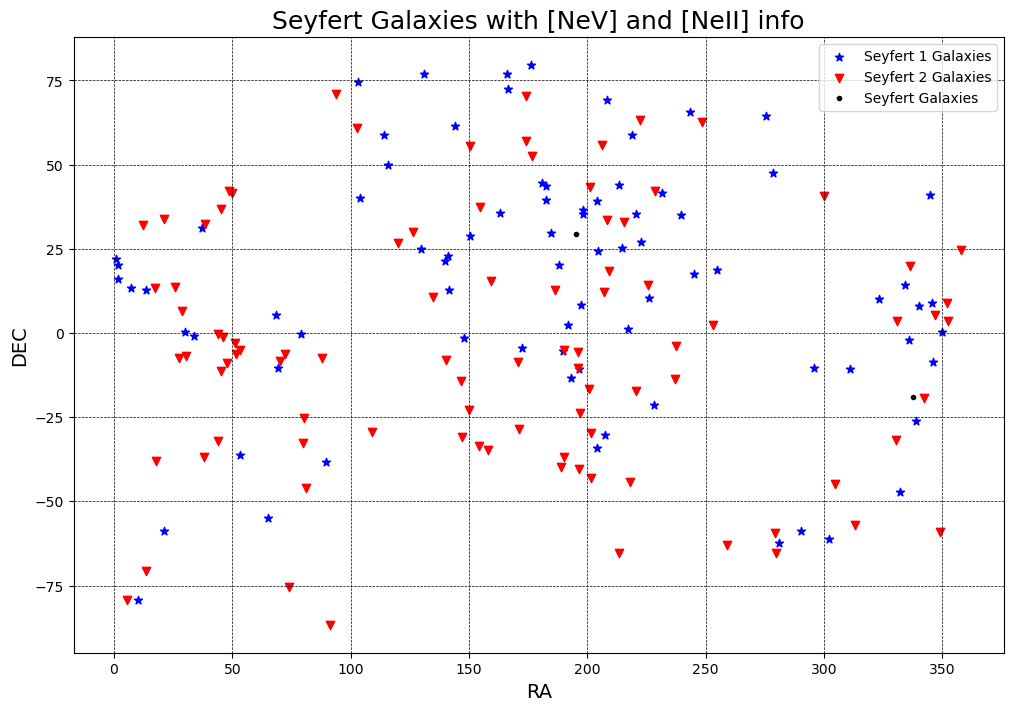

In [26]:
plt.figure(figsize=(12,8))
plt.scatter(Sy1['RA'], Sy1['DEC'], color='blue', marker = '*', label='Seyfert 1 Galaxies')
plt.scatter(Sy2['RA'], Sy2['DEC'], color='red', marker = 'v', label='Seyfert 2 Galaxies')
plt.scatter(SyG['RA'], SyG['DEC'], color='black', marker = '.', label='Seyfert Galaxies')
plt.xlabel(r'RA', fontsize=14)
#plt.xscale('log')
plt.ylabel(r'DEC', fontsize=14)
#plt.ylim(0.0,1.0)
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.title(r'Seyfert Galaxies with [NeV] and [NeII] info', fontsize=18)
plt.legend()
#plt.savefig(path_graphs+'NeIII_NeII_vs_fracAGN_Sy.jpg')
plt.show()

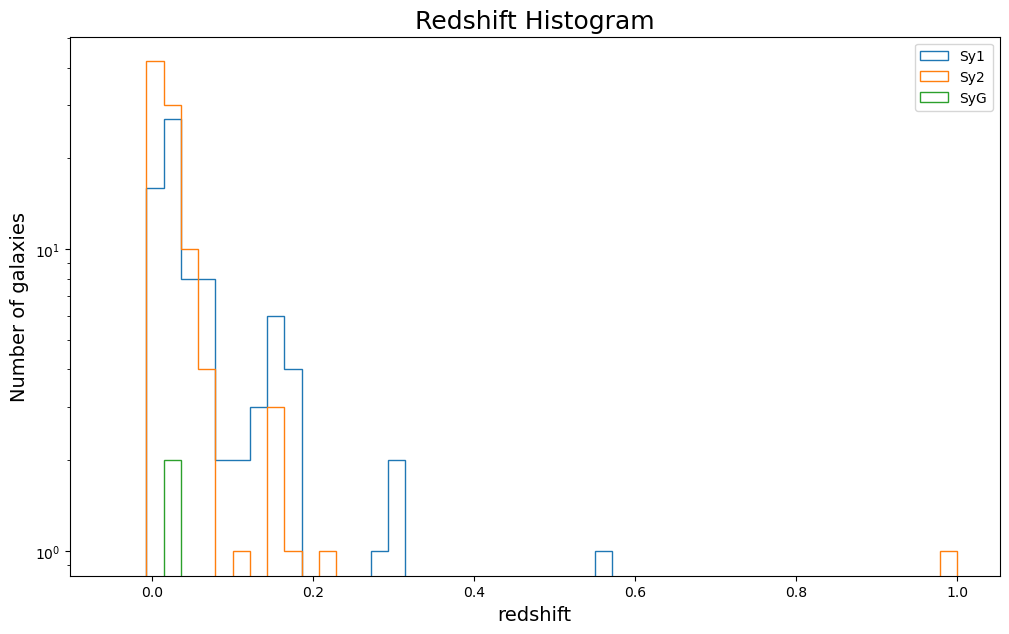

In [27]:
x_Sy1 = Sy1['redshift']
x_Sy2 = Sy2['redshift']
x_SyG = SyG['redshift']
bins_Sy1 = np.linspace(-0.05,1,50)
bins_Sy2 = np.linspace(-0.05,1,50)
bins_SyG = np.linspace(-0.05,1,50)
plt.figure(figsize=(12,7))
plt.hist(x_Sy1, bins=bins_Sy1, histtype='step', label='Sy1')
plt.hist(x_Sy2, bins=bins_Sy2, histtype='step', label='Sy2')
plt.hist(x_SyG, bins=bins_SyG, histtype='step', label='SyG')
plt.xlabel('redshift',fontsize=14)
#plt.xscale('log')
plt.ylabel('Number of galaxies',fontsize=14)
plt.yscale('log')
plt.title('Redshift Histogram', fontsize=18)
plt.legend()

In [28]:
min(Sy2['redshift'])

0.0014490516114409324

In [29]:
max(Sy2['redshift'])

0.987997